In [1]:
from dscribe.descriptors import SOAP, MBTR, CoulombMatrix
from ase.io import read
from ase.neighborlist import NeighborList

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [2]:
import os
import warnings
from glob import glob

import numpy as np
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdFingerprintGenerator import (
    FingeprintGenerator64,
    GetAtomPairGenerator,
    GetMorganGenerator,
    GetRDKitFPGenerator,
    GetTopologicalTorsionGenerator,
)

from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures



# Settings the warnings to be ignored
warnings.filterwarnings("ignore")

RDLogger.DisableLog("rdApp.*")
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 600, 600


morgan_fpgen = GetMorganGenerator(radius=3, fpSize=2048, includeChirality=True)
atompair_fpgen = GetAtomPairGenerator(fpSize=2048, includeChirality=True)
rdkit_fpgen = GetRDKitFPGenerator(fpSize=2048)
topological_torsion_fpgen = GetTopologicalTorsionGenerator(fpSize=2048)


In [3]:
df = pd.read_csv("data/BDE.csv")

def add_path(row: pd.Series):
    sdf_path = "-".join(row["M"].split("-")[:-1])
    row["path"] = f"data/sdf/M/{sdf_path}.sdf"
    return row

def add_path_v2000(row: pd.Series):
    sdf_path_v2000 = "-".join(row["M"].split("-")[:-1])
    row["path_v2000"] = f"data/sdf/M_V2000/{sdf_path_v2000}.sdf"
    return row

def process_row(row: pd.Series):
    if os.path.exists(row["path"]):
        mol = Chem.MolFromMolFile(row["path"], removeHs=False)
    else:
        return None
    if mol is None:
        return None
    row["smiles"] = Chem.MolToSmiles(mol)
    return row


df = df.apply(add_path, axis=1)

df = df.apply(add_path_v2000, axis=1)

df = df.apply(process_row, axis=1).dropna()

print(df)

                         M         BDE                             path  \
0    0013-3FeTMCBrOH2-FeBR   48.565459  data/sdf/M/0013-3FeTMCBrOH2.sdf   
1     0013-3FeTMCBrOH2-FeO   65.854027  data/sdf/M/0013-3FeTMCBrOH2.sdf   
2    0013-3FeTMCClOH2-FeCL   61.285134  data/sdf/M/0013-3FeTMCClOH2.sdf   
3     0013-3FeTMCClOH2-FeO   69.387782  data/sdf/M/0013-3FeTMCClOH2.sdf   
4      0013-3FeTMCFOH2-FeF   98.539418   data/sdf/M/0013-3FeTMCFOH2.sdf   
..                     ...         ...                              ...   
884   0293-3FeEgtBClP-FeCL  107.548403   data/sdf/M/0293-3FeEgtBClP.sdf   
885     0293-5FeEgtBFP-FeF  157.897258    data/sdf/M/0293-5FeEgtBFP.sdf   
886    0293-5FeEgtBN3P-FeN  109.654920   data/sdf/M/0293-5FeEgtBN3P.sdf   
887   0293-5FeEgtBNCSP-FeN  123.912692  data/sdf/M/0293-5FeEgtBNCSP.sdf   
888    0293-5FeEgtBOHP-FeO  126.132891   data/sdf/M/0293-5FeEgtBOHP.sdf   

                                path_v2000  \
0    data/sdf/M_V2000/0013-3FeTMCBrOH2.sdf   
1    da

In [4]:
fe_o = Chem.MolFromSmarts("[Fe]-[OH]")
fe_other = Chem.MolFromSmarts("[Fe]-[NH0,SH0,FH0,ClH0,BrH0,IH0]")
fe_o_break = AllChem.ReactionFromSmarts("[Fe:1]-[OH:2]>>[Fe:1].[OH:2]")
fe_other_break = AllChem.ReactionFromSmarts(
    "[Fe:1]-[NH0,SH0,FH0,ClH0,BrH0,IH0:2]>>[Fe:1].[NH0,SH0,FH0,ClH0,BrH0,IH0:2]"
)

In [5]:
def mol_break_bond(mol: Chem.Mol):
    if mol.HasSubstructMatch(fe_o):
        fe, other = fe_o_break.RunReactants((mol,))[0]
    elif mol.HasSubstructMatch(fe_other):
        fe, other = fe_other_break.RunReactants((mol,))[0]
    else:
        return None, None
    Chem.SanitizeMol(fe)
    Chem.SanitizeMol(other)
    return fe, other


def get_mol_fp(mol: Chem.Mol, fpgen: FingeprintGenerator64) -> np.ndarray:
    if isinstance(fpgen, FingeprintGenerator64):
        return fpgen.GetCountFingerprintAsNumPy(mol)
    elif hasattr(fpgen, 'transform'):
        return fpgen.transform([mol])[0] 
    else:
        raise ValueError(f"Unsupported fingerprint generator: {type(fpgen)}")


def gen_fp_row(row: pd.Series, fpgen: FingeprintGenerator64):
    mol = Chem.MolFromSmiles(row["smiles"])
    fe, other = mol_break_bond(mol)
    if fe is None or other is None:
        return None
    fp_mol = get_mol_fp(mol, fpgen)
    fp_fe = get_mol_fp(fe, fpgen)
    fp_other = get_mol_fp(other, fpgen)
    return np.concatenate([fp_mol, fp_fe, fp_other], dtype=np.int64)

def feature_selection_with_rf(X, y, max_features=150):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y) 
    selector = SelectFromModel(rf, max_features=max_features)
    X_selected = selector.transform(X)
    return X_selected

dcf = DropConstantFeatures()
ddf = DropDuplicateFeatures()

In [6]:
morgan_fps = df.apply(gen_fp_row, axis=1, result_type="expand", fpgen=morgan_fpgen)
morgan_fps["bde"] = df["BDE"]
bde_nan_values = morgan_fps.loc[morgan_fps.isna().any(axis=1), "bde"].tolist()
print(bde_nan_values)
morgan_fps.dropna(inplace=True)
morgan_fps.reset_index(drop=True, inplace=True)
morgan_fps = dcf.fit_transform(morgan_fps)
morgan_fps = ddf.fit_transform(morgan_fps)
morgan_fps_X = morgan_fps.drop(columns=["bde"]).values
morgan_fps_y = morgan_fps["bde"].values
morgan_fps_X_selected = feature_selection_with_rf(morgan_fps_X, morgan_fps_y, max_features=150)
morgan_fps_selected = pd.DataFrame(morgan_fps_X_selected, columns=[f"selected_{i}" for i in range(morgan_fps_X_selected.shape[1])])
morgan_fps_selected["bde"] = morgan_fps_y
print(morgan_fps_selected)

[58.35336913, 124.2475586, 123.4193508, 130.3432309, 125.3390608, 55.76689528, 68.03877953, 68.13076873]
     selected_0  selected_1  selected_2  selected_3  selected_4  selected_5  \
0           0.0         0.0         0.0         0.0         0.0         0.0   
1           0.0         0.0         0.0         0.0         0.0         0.0   
2           0.0         0.0         0.0         0.0         0.0         0.0   
3           0.0         0.0         0.0         0.0         0.0         0.0   
4           0.0         0.0         0.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
875         1.0         0.0         0.0         1.0         3.0         2.0   
876         1.0         0.0         0.0         1.0         3.0         2.0   
877         1.0         0.0         0.0         0.0         3.0         1.0   
878         2.0         0.0         0.0         1.0         3.0         2.0   
879         1.0         0.

In [7]:
def add_key_atom_nums_todf(df):
    key_atom_nums = []
    for idx, row in df.iterrows():
        M = row['M']
        sdf_path = row['path_v2000']
        key_atom_symbol = M.split('-')[-1][2:]  
        key_atom_symbol = key_atom_symbol.upper()  
        mols = Chem.SDMolSupplier(sdf_path, removeHs=False)
        mol = next(mols, None) 
        if not mol:
            key_atom_nums.append(None)
            continue
        fe_idx = None
        key_idx = None
        for atom in mol.GetAtoms():
            symbol = atom.GetSymbol().upper()
            if symbol == 'FE':
                fe_idx = atom.GetIdx()
            elif symbol == key_atom_symbol:
                key_idx = atom.GetIdx()
        key_atom_nums.append([fe_idx, key_idx])
    
    df['key_atom_nums'] = key_atom_nums
    return df

df = add_key_atom_nums_todf(df)
# df.drop(columns=['fe_index', 'key_atom_index'], inplace=True)
# print(df)

def Get_Key_atom_num(df, sdf_path):
    matching_row = df[df['path_v2000'] == sdf_path]
    if not matching_row.empty:
        return matching_row['key_atom_nums'].values[0]
    else:
        return None 


In [8]:

def get_SOAP(atoms, soap, key_atom_num=None):
    atom_nums = atoms.get_atomic_numbers()
    for i in range(len(atom_nums)):
        if atom_nums[i] > 13 and atom_nums[i] not in [16, 26, 17, 35]: 
            atom_nums[i] = 1  
        elif atom_nums[i] == 5:  
            atom_nums[i] = 1
    atoms.set_atomic_numbers(atom_nums)  
    mol_soap = soap.create(atoms, centers=[key_atom_num]) 
    return mol_soap

def SOAP_Definition(species=None):
    if not species:
        species = ["H", "C", "N", "O", "F", "S", "Cl", "Br", "Fe"]
    r_cut = 6.0
    n_max = 8
    l_max = 6
    soap = SOAP(species=species, periodic=False, r_cut=r_cut, n_max=n_max, l_max=l_max)
    return soap
    
def calculate_SOAP(sdf_file, species=None, soap_len=None):
    atoms = read(sdf_file, format="sdf") 
    soap = SOAP_Definition(species=species) 
    key_atom_nums = Get_Key_atom_num(df, sdf_file)  
    
    soap_results = []
    key_atom_nums = Get_Key_atom_num(df, sdf_file)
    # print(f"Key atom numbers for {sdf_file}: {key_atom_nums}") 
    
    if key_atom_nums is None:
        print(f"Warning: No key atom numbers found for {sdf_file}")
        return []  
    
    soap_results = []
    for key_atom_num in key_atom_nums:
        soap_descriptor = get_SOAP(atoms, soap, key_atom_num)
        if soap_len is not None:
            soap_descriptor = soap_descriptor.flatten()[:soap_len]  
        soap_results.extend(soap_descriptor.flatten())
    
    # print(soap_results)
    return soap_results

soap_results = []

for idx, row in df.iterrows():
    sdf_file = row['path_v2000']
    bde = row['BDE']  
    soap_descriptor = calculate_SOAP(sdf_file, soap_len=2000) 
    result_row = soap_descriptor + [bde]
    soap_results.append(result_row)

soapdescriptor = pd.DataFrame(soap_results)
soapdescriptor.columns = [f"soap_{i}" for i in range(soapdescriptor.shape[1] - 1)] + ['bde']

df_soap_filtered = soapdescriptor[~soapdescriptor["bde"].isin(bde_nan_values)]
df_soap_filtered = df_soap_filtered.reset_index(drop=True)

soap_X = df_soap_filtered.drop(columns=["bde"]).values
soap_y = df_soap_filtered["bde"].values
soap_X_selected = feature_selection_with_rf(soap_X, soap_y, max_features=500)
soap_X_selected_df = pd.DataFrame(soap_X_selected, columns=[f"selected_soap_{i}" for i in range(soap_X_selected.shape[1])])
soap_X_selected_df["bde"] = soap_y
print(soap_X_selected_df)


     selected_soap_0  selected_soap_1  selected_soap_2  selected_soap_3  \
0          18.340954        -0.002853        -0.049116         0.025541   
1          18.340954        -0.002853        -0.049116         0.025541   
2          18.470562        -0.000908        -0.037359         0.017170   
3          18.470562        -0.000908        -0.037359         0.017170   
4          19.286019         0.000445        -0.004590         0.001847   
..               ...              ...              ...              ...   
875         0.569170        -0.121402         0.356109        -2.065537   
876         0.745903        -0.108252         0.331890        -1.819195   
877         0.734018        -0.089909         0.254592        -1.018517   
878         0.598239        -0.054826         0.143273        -0.470118   
879         0.891284        -0.195486         0.646253        -5.200515   

     selected_soap_4  selected_soap_5  selected_soap_6  selected_soap_7  \
0          -0.312388    

In [9]:
print(len(morgan_fps_selected), len(soap_X_selected_df))
print(morgan_fps_selected.index.equals(soap_X_selected_df.index))

880 880
True


In [10]:
from ase import Atoms

mbtr_results = []

for idx, row in df.iterrows():
    sdf_file = row['path_v2000'] 
    bde = row['BDE']  
    supplier = Chem.SDMolSupplier(sdf_file, removeHs=False)
    mol = supplier[0] 
    if mol is None:
        print(f"Skipping {sdf_file}, SDF file loading failed.")
        continue

    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
    conf = mol.GetConformer()
    positions = conf.GetPositions()
    ase_molecule = Atoms(symbols=atoms, positions=positions)

    mbtr_k1 = MBTR(
        species=["C", "H", "O", "N", "S", "P", "B", "Si", "I", "Fe", "K", "F", "Cl", "Br"],
        geometry={"function": "atomic_number"},
        grid={"min": 0, "max": 10, "n": 100, "sigma": 0.1},
        periodic=False,
        normalization="l2",
        sparse=False
    )
    mbtr_output_k1 = mbtr_k1.create(ase_molecule)
    mbtr_output_k1 = mbtr_output_k1[:500]

    mbtr_k2 = MBTR(
        species=["C", "H", "O", "N", "S", "P", "B", "Si", "I", "Fe", "K", "F", "Cl", "Br"],
        geometry={"function": "inverse_distance"},
        grid={"min": 0, "max": 1, "n": 100, "sigma": 0.1},
        weighting={"function": "exp", "scale": 0.5, "threshold": 1e-3},
        periodic=False,
        normalization="l2",
        sparse=False
    )
    mbtr_output_k2 = mbtr_k2.create(ase_molecule)
    mbtr_output_k2 = mbtr_output_k2[:2500]

    mbtr_combined = np.concatenate([mbtr_output_k1, mbtr_output_k2])
    mbtr_results.append(list(mbtr_combined) + [bde])

df_mbtr = pd.DataFrame(mbtr_results)
df_mbtr.columns = [f"mbtr_{i}" for i in range(df_mbtr.shape[1] - 1)] + ['bde']

df_mbtr_filtered = df_mbtr[~df_mbtr["bde"].isin(bde_nan_values)]
df_mbtr_filtered = df_mbtr_filtered.reset_index(drop=True)


mbtr_X = df_mbtr_filtered.drop(columns=["bde"]).values
mbtr_y = df_mbtr_filtered["bde"].values
mbtr_X_selected = feature_selection_with_rf(mbtr_X, mbtr_y, max_features=500)
mbtr_X_selected_df = pd.DataFrame(mbtr_X_selected, columns=[f"selected_mbtr_{i}" for i in range(mbtr_X_selected.shape[1])])
mbtr_X_selected_df["bde"] = mbtr_y
print(mbtr_X_selected_df)

     selected_mbtr_0  selected_mbtr_1  selected_mbtr_2  selected_mbtr_3  \
0           0.001230         0.000483         0.037101         0.078551   
1           0.001230         0.000483         0.037101         0.078551   
2           0.001230         0.000483         0.037101         0.078551   
3           0.001230         0.000483         0.037101         0.078551   
4           0.001230         0.000483         0.037086         0.078521   
..               ...              ...              ...              ...   
875         0.001643         0.001084         0.083273         0.176310   
876         0.001643         0.001084         0.083255         0.176272   
877         0.001616         0.001332         0.102325         0.216648   
878         0.001682         0.001156         0.088774         0.187957   
879         0.001612         0.001063         0.081673         0.172923   

     selected_mbtr_4  selected_mbtr_5  selected_mbtr_6  selected_mbtr_7  \
0           0.065130    

In [11]:
print(len(morgan_fps_selected), len(mbtr_X_selected_df))
print(morgan_fps_selected.index.equals(mbtr_X_selected_df.index))

880 880
True


In [12]:
from scipy.spatial.distance import cdist

coulomb_results = []

for idx, row in df.iterrows():
    sdf_file = row['path']
    bde = row['BDE']
    supplier = Chem.SDMolSupplier(sdf_file, removeHs=False)
    mol = supplier[0]
    if mol is None:
        print(f"Skipping {sdf_file}, SDF file loading failed.")
        continue
    
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
    num_atoms = len(atoms)
    conformer = mol.GetConformer()
    positions = np.array([conformer.GetAtomPosition(i) for i in range(num_atoms)])
    distances = cdist(positions, positions)
    atom_charges = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()])
    coulomb_matrix = np.zeros((num_atoms, num_atoms))
    
    for i in range(num_atoms):
        for j in range(num_atoms):
            if i == j:
                coulomb_matrix[i, j] = 0.5 * atom_charges[i] ** 2
            else:
                coulomb_matrix[i, j] = atom_charges[i] * atom_charges[j] / distances[i, j]

    coulomb_descriptor = coulomb_matrix.flatten()[:1000]
    result_row = list(coulomb_descriptor) + [bde]
    coulomb_results.append(result_row)

df_coulomb = pd.DataFrame(coulomb_results)
df_coulomb.columns = [f"coulomb_{i}" for i in range(df_coulomb.shape[1] - 1)] + ['bde']
df_coulomb_filtered = df_coulomb[~df_coulomb["bde"].isin(bde_nan_values)]
df_coulomb_filtered = df_coulomb_filtered.reset_index(drop=True)
print(df_coulomb_filtered)
# df_coulomb_filtered.to_csv('coulomb_selected_features_with_bde.csv', index=False)

coulomb_X = df_coulomb_filtered.drop(columns=["bde"]).values
coulomb_y = df_coulomb_filtered["bde"].values
coulomb_X_selected = feature_selection_with_rf(coulomb_X, coulomb_y, max_features=500)
coulomb_X_selected_df = pd.DataFrame(coulomb_X_selected, columns=[f"selected_coulomb_{i}" for i in range(coulomb_X_selected.shape[1])])
coulomb_X_selected_df["bde"] = coulomb_y
print(coulomb_X_selected_df)

     coulomb_0  coulomb_1  coulomb_2  coulomb_3  coulomb_4  coulomb_5  \
0        338.0  83.713915  82.543688  82.539867  83.711806  53.430321   
1        338.0  83.713915  82.543688  82.539867  83.711806  53.430321   
2        338.0  83.346032  82.547765  82.529334  83.336634  53.636078   
3        338.0  83.346032  82.547765  82.529334  83.336634  53.636078   
4        338.0  83.409170  81.889860  81.900004  83.417778  54.273074   
..         ...        ...        ...        ...        ...        ...   
875       18.0   5.486380   5.465164  16.575337   2.120154  24.121269   
876       18.0   5.485885   5.464201  16.573920   2.120261  24.116783   
877       18.0   5.486101   5.464583  16.595908   2.124347  24.125227   
878       18.0   5.484965   5.466245  16.639640   2.142812  24.149767   
879       18.0   5.486515   5.463106  16.586813   2.082032  24.113645   

     coulomb_6  coulomb_7  coulomb_8  coulomb_9  ...  coulomb_991  \
0     6.617570   8.222147  51.643866   6.757127  ...  

In [13]:
print(len(morgan_fps_selected), len(coulomb_X_selected_df))
print(morgan_fps_selected.index.equals(coulomb_X_selected_df.index))

880 880
True


In [14]:
import tqdm
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

random_seed = 42

In [15]:
param_grid = {
    "LR": {},
    "RF": {
        "n_estimators": [100, 200, 300, 400, 500, 600],
        "max_depth": [None, 5, 10, 15, 20],
    },
    "ET": {
        "n_estimators": [100, 200, 300, 400, 500, 600],
        "max_depth": [None, 5, 10, 15, 20],
    },
    "KNN": {"n_neighbors": [5, 10, 15], "leaf_size": [25, 30, 35]},
    "DT": {
        "max_depth": [
            None,
            10,
            20,
        ],
        "min_samples_split": [2, 4, 6],
    },
    "GBR": {
        "n_estimators": [100, 200, 300, 400, 500, 600],
        "max_depth": [5, 10, 15, 20],
    },
    "ABR": {
        "n_estimators": [100, 200, 300, 400, 500, 600],
    },
    "HGBR": {
        "max_depth": [5, 10, 15, 20],
        "min_samples_leaf": [5, 10, 15, 20],
    },
}
models = {
    "LR": LinearRegression(n_jobs=-1),
    "RF": RandomForestRegressor(n_jobs=-1, random_state=random_seed),
    "ET": ExtraTreesRegressor(n_jobs=-1, random_state=random_seed),
    "KNN": KNeighborsRegressor(n_jobs=-1),
    "DT": DecisionTreeRegressor(random_state=random_seed),
    "GBR": GradientBoostingRegressor(random_state=random_seed),
    "ABR": AdaBoostRegressor(random_state=random_seed),
    "HGBR": HistGradientBoostingRegressor(random_state=random_seed),
}

In [16]:
train_bde = pd.read_csv("trainBDE.csv") 
train_bde_values = set(train_bde["BDE"]) 
train_index = morgan_fps_selected[morgan_fps_selected["bde"].isin(train_bde_values)].index
test_index = morgan_fps_selected[~morgan_fps_selected["bde"].isin(train_bde_values)].index

train_val, test_val = (
    morgan_fps_selected["bde"].iloc[train_index],
    morgan_fps_selected["bde"].iloc[test_index],
)

descs = {
    "Morgan": morgan_fps_selected,
    "SOAP": soap_X_selected_df,
    "MBTR": mbtr_X_selected_df,
    "CoulombMatrix": coulomb_X_selected_df,
    
}

In [17]:
best_params = {}
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
with tqdm.tqdm(total=len(models) * len(descs)) as pbar:
    for model_name, model in models.items():
        for desc_name, desc in descs.items():
            train_desc = desc.drop("bde", axis=1)
            train_val = desc["bde"]
            GS = GridSearchCV(
                model, param_grid[model_name], cv=kfold, n_jobs=-1, scoring="r2"
            )
            GS.fit(train_desc, train_val)
            best_param = model.get_params()
            best_param.update(GS.best_params_)
            best_score = GS.best_score_

            best_params[(model_name, desc_name)] = best_param
            pbar.set_postfix_str(
                s="Model: {:4s}, Desc: {:8s}, Best Socre: {:4f}, Best Param: {}".format(
                    model_name, desc_name, best_score, best_param
                )
            )
            pbar.update()

 16%|█▌        | 5/32 [00:28<04:12,  9.37s/it, Model: RF  , Desc: Morgan  , Best Socre: 0.789375, Best Param: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}]

100%|██████████| 32/32 [52:17<00:00, 98.05s/it, Model: HGBR, Desc: CoulombMatrix, Best Socre: 0.685350, Best Param: {'categorical_features': 'warn', 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': 5, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'quantile': None, 'random_state': 42, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}]    


In [18]:
np.save(os.path.join("result", "hyperparameters_opt_Morgan3D.npy"), best_params)

In [19]:
from scipy.stats import pearsonr
import re


performance_result = []
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
for model_name, desc_name in best_params.keys():
    desc = descs[desc_name]
    train_val = desc["bde"]
    test_val = train_val.iloc[test_index]

    desc = desc.drop("bde", axis=1)
    model = models[model_name]
    model.set_params(**best_params[(model_name, desc_name)])
    train_desc = desc.iloc[train_index]
    train_val = train_val.iloc[train_index]
    test_desc = desc.iloc[test_index]
    all_test_p, all_test_y = [], []
    for train_idx, test_idx in kfold.split(train_desc):
        train_x, test_x = train_desc.iloc[train_idx], train_desc.iloc[test_idx]
        train_y, test_y = (
            train_val.iloc[train_idx],
            train_val.iloc[test_idx],
        )
        model.fit(train_x, train_y)
        test_p = model.predict(test_desc)
        all_test_p.append(test_p)
        all_test_y.append(test_val)
    all_test_p = np.concatenate(all_test_p)
    all_test_y = np.concatenate(all_test_y)
    performance_result.append(
        pd.DataFrame(
            {
                "$yield_{observed}$": all_test_y,
                "$yield_{pred}$": all_test_p,
                "model": model_name,
                "desc": desc_name,
                "r2": r2_score(all_test_y, all_test_p),
                "mae": mean_absolute_error(all_test_y, all_test_p),
                "pearson_r": pearsonr(all_test_y, all_test_p)[0],
                "rmse": root_mean_squared_error(all_test_y, all_test_p),
            }
        )
    )
    print(
        f"Model: {model_name:10s}, Desc: {desc_name:10s}, R2: {r2_score(all_test_y, all_test_p):.4f}, "
        f"PearsonR: {pearsonr(all_test_y, all_test_p)[0]:.4f}, MAE: {mean_absolute_error(all_test_y, all_test_p):.4f}, "
        f"RMSE: {root_mean_squared_error(all_test_y, all_test_p):.4f}"
    )

Model: LR        , Desc: Morgan    , R2: 0.1889, PearsonR: 0.7002, MAE: 19.0201, RMSE: 25.7201
Model: LR        , Desc: SOAP      , R2: -51.9113, PearsonR: 0.1360, MAE: 93.7509, RMSE: 207.7351
Model: LR        , Desc: MBTR      , R2: 0.0574, PearsonR: 0.5472, MAE: 20.6864, RMSE: 27.7273
Model: LR        , Desc: CoulombMatrix, R2: -4.1222, PearsonR: -0.0860, MAE: 50.1104, RMSE: 64.6345
Model: RF        , Desc: Morgan    , R2: 0.5291, PearsonR: 0.7280, MAE: 15.7419, RMSE: 19.5983
Model: RF        , Desc: SOAP      , R2: 0.5708, PearsonR: 0.8125, MAE: 15.1444, RMSE: 18.7105
Model: RF        , Desc: MBTR      , R2: 0.1942, PearsonR: 0.6091, MAE: 21.4346, RMSE: 25.6354
Model: RF        , Desc: CoulombMatrix, R2: -0.2445, PearsonR: 0.0141, MAE: 25.3964, RMSE: 31.8586
Model: ET        , Desc: Morgan    , R2: 0.6276, PearsonR: 0.7954, MAE: 13.7011, RMSE: 17.4268
Model: ET        , Desc: SOAP      , R2: 0.6148, PearsonR: 0.8270, MAE: 14.3860, RMSE: 17.7237
Model: ET        , Desc: MBTR      , R

In [20]:
performance_result_df = pd.concat(performance_result)
performance_result_df.to_csv(os.path.join("result", "performance_result_MorganVS3D.csv"))

In [21]:
performance_result_df

,$yield_{observed}$,$yield_{pred}$,model,desc,r2,mae,pearson_r,rmse
0,48.565459,74.528827,LR,Morgan,0.188899,19.020054,0.700164,25.720135
1,65.854027,74.528827,LR,Morgan,0.188899,19.020054,0.700164,25.720135
2,61.285134,74.076075,LR,Morgan,0.188899,19.020054,0.700164,25.720135
3,69.387782,74.076075,LR,Morgan,0.188899,19.020054,0.700164,25.720135
4,98.539418,129.765142,LR,Morgan,0.188899,19.020054,0.700164,25.720135
...,...,...,...,...,...,...,...,...
3795,53.290440,79.301567,HGBR,CoulombMatrix,-0.211559,24.678127,0.053369,31.434606
3796,63.496935,83.426752,HGBR,CoulombMatrix,-0.211559,24.678127,0.053369,31.434606
3797,89.930222,83.426752,HGBR,CoulombMatrix,-0.211559,24.678127,0.053369,31.434606
3798,35.099279,73.179235,HGBR,CoulombMatrix,-0.211559,24.678127,0.053369,31.434606


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

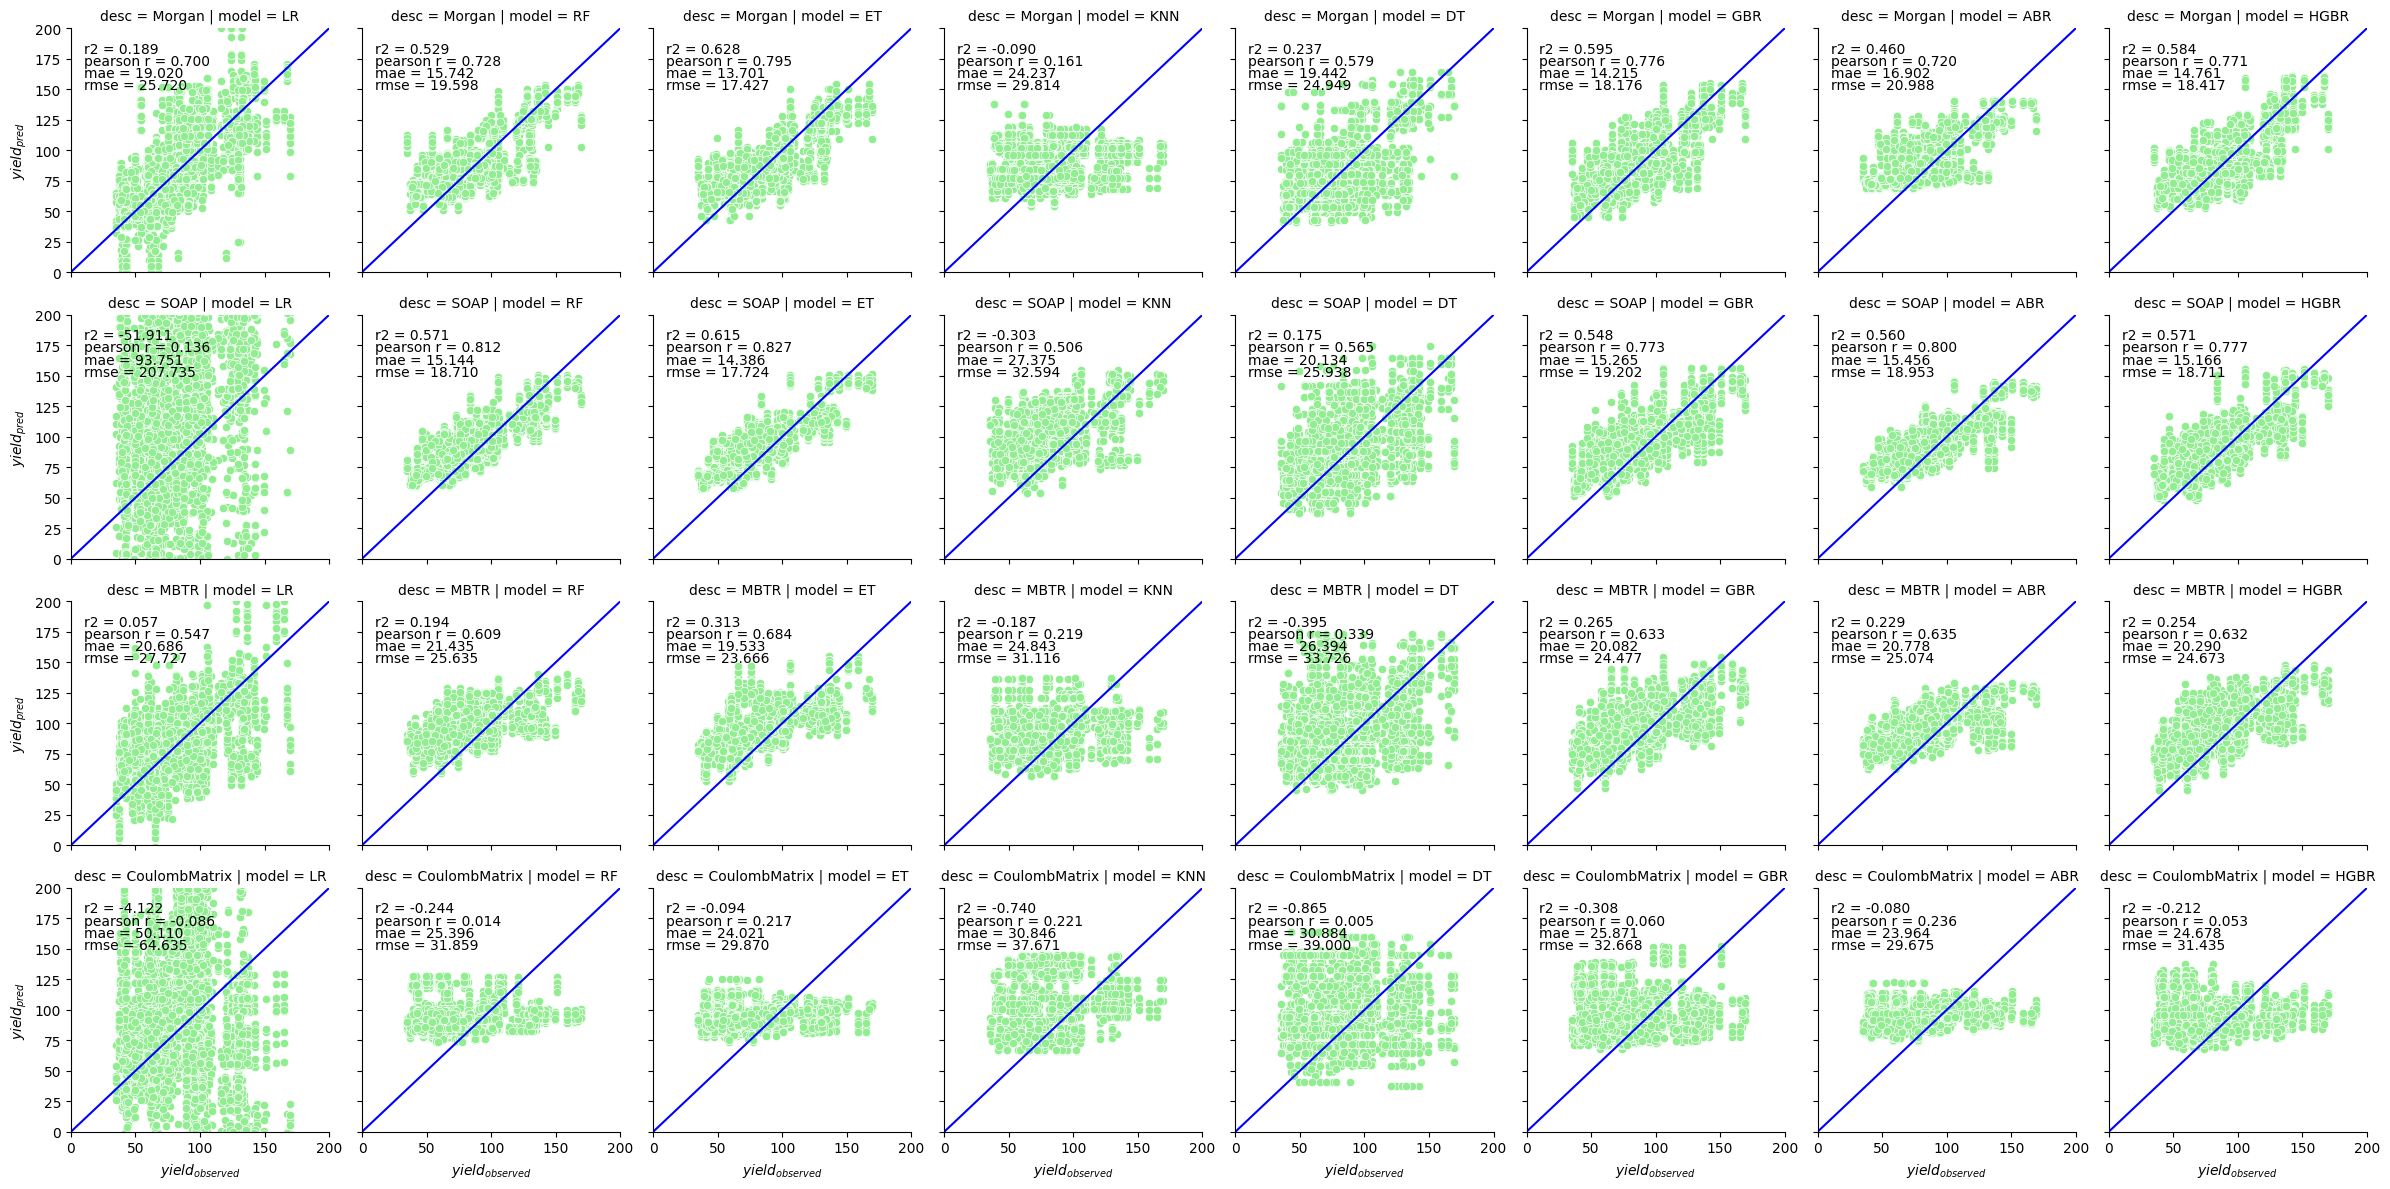

In [23]:
def annotate(data, **kws):
    ax = plt.gca()
    ax.text(0.05, 0.9, f"r2 = {data['r2'].iloc[0]:5.3f}", transform=ax.transAxes)
    ax.text(
        0.05,
        0.85,
        f"pearson r = {data['pearson_r'].iloc[0]:.3f}",
        transform=ax.transAxes,
    )
    ax.text(0.05, 0.8, f"mae = {data['mae'].iloc[0]:.3f}", transform=ax.transAxes)
    ax.text(0.05, 0.75, f"rmse = {data['rmse'].iloc[0]:.3f}", transform=ax.transAxes)
    ax.plot(np.linspace(0, 200, 200), np.linspace(0, 200, 200), color="blue")


g = sns.FacetGrid(
    performance_result_df, col="model", row="desc", xlim=(0, 200), ylim=(0, 200)
)
g.map_dataframe(
    sns.scatterplot, "$yield_{observed}$", "$yield_{pred}$", color="lightgreen"
)
g.map_dataframe(annotate)

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def annotate(data, **kws):
    ax = plt.gca()
    # Use LaTeX formatting for R²
    ax.text(0.02, 0.95, f"$R^2$ = {data['r2'].iloc[0]:5.3f}", transform=ax.transAxes, fontsize=9)
    ax.text(
        0.02,
        0.90,
        f"Pearson r = {data['pearson_r'].iloc[0]:.3f}",
        transform=ax.transAxes,
    )
    ax.text(0.02, 0.85, f"MAE = {data['mae'].iloc[0]:.2f}", transform=ax.transAxes)
    ax.text(0.02, 0.80, f"RMSE = {data['rmse'].iloc[0]:.3f}", transform=ax.transAxes)
    ax.plot(np.linspace(20, 200, 200), np.linspace(20, 200, 200), color="red")

models = performance_result_df["model"].unique()

for model in models:
    g = sns.FacetGrid(
        performance_result_df[performance_result_df["model"] == model], 
        col="desc",  
        col_wrap=4, 
        xlim=(0, 200), 
        ylim=(0, 200),
        height=4, 
        aspect=1
    )
    
    g.map_dataframe(
        sns.scatterplot, "$yield_{observed}$", "$yield_{pred}$", color="blue", s=12
    )
    g.map_dataframe(annotate)
    g.set_axis_labels("$BDE_{DFT}$", "$BDE_{ML}$")
    g.set_titles(col_template="descriptor = {col_name}", size=12, pad=10)
    g.fig.suptitle(f"{model}_performance", fontsize=14, y=1.00)  
    g.fig.tight_layout()
    g.fig.subplots_adjust(hspace=0.2)  
    g.savefig(f"{model}_performance_MorganVS3D.png")
    plt.close(g.fig)  


In [34]:
#Figure S11

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def annotate(data, **kws):
    ax = plt.gca()
    # Use LaTeX formatting for R²
    ax.text(0.02, 0.95, f"$R^2$ = {data['r2'].iloc[0]:5.3f}", 
            transform=ax.transAxes, fontsize=9)
    ax.text(0.02, 0.90, 
            f"Pearson r = {data['pearson_r'].iloc[0]:.3f}",
            transform=ax.transAxes)
    ax.text(0.02, 0.85, f"MAE = {data['mae'].iloc[0]:.2f}", 
            transform=ax.transAxes)
    ax.text(0.02, 0.80, f"RMSE = {data['rmse'].iloc[0]:.3f}", 
            transform=ax.transAxes)
    ax.plot(np.linspace(20, 200, 200), np.linspace(20, 200, 200), 
            color="red", linewidth=1)

selected_models = ["RF", "ET", "GBR", "ABR", "HGBR"]
selected_descs = ["Morgan", "SOAP"]

filtered_df = performance_result_df[
    (performance_result_df["model"].isin(selected_models)) & 
    (performance_result_df["desc"].isin(selected_descs))
]

g = sns.FacetGrid(
    filtered_df,
    row="model",  
    col="desc",   
    margin_titles=True,
    xlim=(0, 200), 
    ylim=(0, 200),
    height=3,    
    aspect=1.2,   
    despine=False
)

g.map_dataframe(
    sns.scatterplot, 
    "$yield_{observed}$", "$yield_{pred}$", 
    color="blue", 
    s=15,        
    alpha=0.6      
)

g.map_dataframe(annotate)

g.set_axis_labels(
    "$BDE_{DFT}$ ",  
    "$BDE_{ML}$ ", 
    fontsize=10
)

g.set_titles(
    row_template="{row_name}", 
    col_template="{col_name}", 
    size=11
)

plt.subplots_adjust(
    hspace=0.15, 
    wspace=0.15 
)

g.fig.suptitle("Model Performance Comparison (Morgan vs SOAP)", 
              y=1.02,  
              fontsize=10)

for ax in g.axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=8)

g.savefig(
    "Selected_Models_Performance.png",
    dpi=300,         
    bbox_inches='tight' 
)
plt.close(g.fig)